# Openpiv-python-gpu Tutorial

Use the following link to run this using GPUs from Google Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ericyang125/openpiv-python-gpu/blob/master/Openpiv_Python_Tutorial_Basic.ipynb)

Ensure that GPU acceleration is enabled in Google Colab: Runtime > Change runtime type.


## Introduction


This tutorial will demonstrate how to use the GPU functionality of openpiv-python-gpu. OpenPIV will be installed to this VM and a single image pair will be processed.


## Function Documentation


### openpiv.gpu_process.gpu_piv(frame_a, frame_b, **pars)


    """An iterative GPU-accelerated algorithm that uses translation and deformation of interrogation windows.

    At every iteration, the estimate of the displacement and gradient are used to shift and deform the interrogation
    windows used in the next iteration. One or more iterations can be performed before the estimated velocity is
    interpolated onto a finer mesh. This is done until the final mesh and number of iterations is met.

    Algorithm Details
    -----------------
    Only window sizes that are multiples of 8 are supported now, and the minimum window size is 8.
    Windows are shifted symmetrically to reduce bias errors.
    The displacement obtained after each correlation is the residual displacement dc.
    The new displacement is computed by dx = dpx + dcx and dy = dpy + dcy.
    Validation is done by any combination of signal-to-noise ratio, mean, median and rms velocities.
    Smoothn can be used between iterations to improve the estimate and replace missing values.

    References
    ----------
    Scarano F, Riethmuller ML (1999) Iterative multigrid approach in PIV image processing with discrete window offset.
        Exp Fluids 26:513–523
    Meunier, P., & Leweke, T. (2003). Analysis and treatment of errors due to high velocity gradients in particle image
        velocimetry.
        Experiments in fluids, 35(5), 408-421.
    Garcia, D. (2010). Robust smoothing of gridded data in one and higher dimensions with missing values.
        Computational statistics & data analysis, 54(4), 1167-1178.

    Parameters
    ----------
    frame_a, frame_b : ndarray
        2D int, integers containing grey levels of the first and second frames.
    mask : ndarray or None, optional
        2D, int, array of integers with values 0 for the background, 1 for the flow-field. If the center of a window is
        on a 0 value the velocity is set to 0.
    window_size_iters : tuple or int, optional
        Number of iterations performed at each window size
    min_window_size : tuple or int, optional
        Length of the sides of the square deformation. Only supports multiples of 8.
    overlap_ratio : float, optional
        Ratio of overlap between two windows (between 0 and 1).
    dt : float, optional
        Time delay separating the two frames.
    deform : bool, optional
        Whether to deform the windows by the velocity gradient at each iteration.
    smooth : bool, optional
        Whether to smooth the intermediate fields.
    nb_validation_iter : int, optional
        Number of iterations per validation cycle.
    validation_method : {tuple, 's2n', 'median_velocity', 'mean_velocity', 'rms_velocity'}, optional
        Method used for validation. Only the mean velocity method is implemented now. The default tolerance is 2 for
        median validation.

    Returns
    -------
    x, y : ndarray
        2D, Coordinates where the PIV-velocity fields have been computed.
    u, v : ndarray
        2D, Velocity fields in pixel/time units.
    mask : ndarray
        2D, the boolean values (True for vectors interpolated from previous iteration).
    s2n : ndarray
        2D, the signal to noise ratio of the final velocity field.

    Other Parameters
    ----------------
    trust_1st_iter : bool
        With a first window size following the 1/4 rule, the 1st iteration can be trusted and the value should be 1.
    s2n_tol, median_tol, mean_tol, median_tol, rms_tol : float
        Tolerance of the validation methods.
    smoothing_par : float
        Smoothing parameter to pass to smoothn to apply to the intermediate velocity fields.
    extend_ratio : float
        Ratio the extended search area to use on the first iteration. If not specified, extended search will not be
        used.
    subpixel_method : {'gaussian'}
        Method to estimate subpixel location of the peak.
    return_sig2noise : bool
        Sets whether to return the signal-to-noise ratio. Not returning the signal-to-noise speeds up computation
        significantly, which is default behaviour.
    sig2noise_method : {'peak2peak', 'peak2mean'}
        Method of signal-to-noise-ratio measurement.
    s2n_width : int
        Half size of the region around the first correlation peak to ignore for finding the second peak. Default is 2.
        Only used if sig2noise_method==peak2peak.
    n_fft : int or tuple
        Size-factor of the 2D FFT in x and y-directions. The default of 2 is recommended.

    Example
    -------
    x, y, u, v, mask, s2n = gpu_piv(frame_a, frame_b, mask=None, window_size_iters=(1, 2), min_window_size=16,
    overlap_ratio=0.5, dt=1, deform=True, smooth=True, nb_validation_iter=2, validation_method='median_velocity',
    median_tol=2)

    """

## Usage Example

In this example, a single pair of particle images is processed using the iterative GPU function openpiv.gpu_process.gpu_piv().
Cross-correlation is performed using 32 x 32 pixel windows, then twice at 16 x 16 pixel windows.
Both windows displacement and deformation are used.
Validation is performed using the median criterion.


### Install OpenPIV


In [1]:
# Uninstall the current version of CUDA
!apt remove cuda-*
!apt autoremove
!apt update

# Install CUDA 11.1
!apt install nvidia-cuda-toolkit

# Check that GPU is connected and correct version of CUDA toolkit is installed. Should say CUDA Version 11.1
!nvidia-smi
!nvcc --version


Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'cuda-cusparse-cross-qnx-10-0' for glob 'cuda-*'
Note, selecting 'cuda-toolkit-11-3-config-common' for glob 'cuda-*'
Note, selecting 'cuda-nsight-compute-11-0' for glob 'cuda-*'
Note, selecting 'cuda-nsight-compute-11-1' for glob 'cuda-*'
Note, selecting 'cuda-nsight-compute-11-2' for glob 'cuda-*'
Note, selecting 'cuda-nsight-compute-11-3' for glob 'cuda-*'
Note, selecting 'cuda-nsight-compute-11-4' for glob 'cuda-*'
Note, selecting 'cuda-nsight-compute-11-5' for glob 'cuda-*'
Note, selecting 'cuda-nsight-compute-11-6' for glob 'cuda-*'
Note, selecting 'cuda-nsight-compute-11-7' for glob 'cuda-*'
Note, selecting 'cuda-nvprof-11-0' for glob 'cuda-*'
Note, selecting 'cuda-nvprof-11-1' for glob 'cuda-*'
Note, selecting 'cuda-nvprof-11-2' for glob 'cuda-*'
Note, selecting 'cuda-nvprof-11-3' for glob 'cuda-*'
Note, selecting 'cuda-nvprof-11-4' for glob 'cuda-*'
Note, selecting 'c

In [2]:
# Install PyCUDA.
!pip install pycuda

# Install scikit-CUDA.
!pip install scikit-CUDA

# Install other requirements which may already be fulfilled.
!pip install imageio numpy matplotlib setuptools

# Clone the repo.
!git clone https://github.com/ericyang125/openpiv-python-gpu.git

# Install OpenPIV extensions.
!cd openpiv-python-gpu && python3 setup.py build_ext --inplace


     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 5.3 MB/s 
     |████████████████████████████████| 69 kB 6.9 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626578 sha256=79dd8b7cbf955e0da8d6973a6dd0b9172cf5618ead6e0f14239354be3e6ec474
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2022.1.7-py2.py3-none-any.whl size=64772 sha256=090cf3bed2d446c8b59af8e7c06ffba7909261ed00760812c7168d6273fcc0cf
  Stored in directory: /root/.cache/pip/wheels/24/c3/8d/9b093180175460a5fc613220b26027ae97cecbbf94fd3822af
Successfully built pycuda pytools
     |████████████████████████████████| 114 kB 5.5 MB/s 
Cloning into 'openpiv-python-gpu'...
remote: Enumerating objects: 6811, done.


### Load data

In [3]:
!wget https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/data/test1/exp1_001_a.bmp
!wget https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/data/test1/exp1_001_b.bmp


--2022-05-17 20:30:44--  https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/data/test1/exp1_001_a.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190006 (186K) [image/bmp]
Saving to: ‘exp1_001_a.bmp’

exp1_001_a.bmp      100%[===================>] 185.55K  --.-KB/s    in 0.02s   

2022-05-17 20:30:45 (7.57 MB/s) - ‘exp1_001_a.bmp’ saved [190006/190006]

--2022-05-17 20:30:45--  https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/data/test1/exp1_001_b.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awai

### Python Example

In [4]:
import os
import sys
import numpy
import imageio as io
import matplotlib.pyplot as plt
%matplotlib inline

# Add OpenPIV to the python path.
sys.path.append(os.path.join(os.getcwd(), 'openpiv-python-gpu/'))

# Import the GPU module and the tools module.
import openpiv.gpu_process as gpu_process
import openpiv.tools as tools

# PIV parameters:
pars = {
'mask': None,
'window_size_iters': (1, 2),
'min_window_size': 16,
'overlap_ratio': 0.5,
'dt': 1,
'nb_validation_iter': 1,
'validation_method': 'median_velocity',
}

# The images are loaded using imageio.
frame_a = io.imread('exp1_001_a.bmp')
frame_b = io.imread('exp1_001_b.bmp')

# The velocity fields are computed.
x, y, u, v, mask, s2n = gpu_process.gpu_piv(frame_a, frame_b, **pars)

# Save the results to a text file.
tools.save(x, y, u, v, mask, 'exp1_001_gpu.txt')


Results:

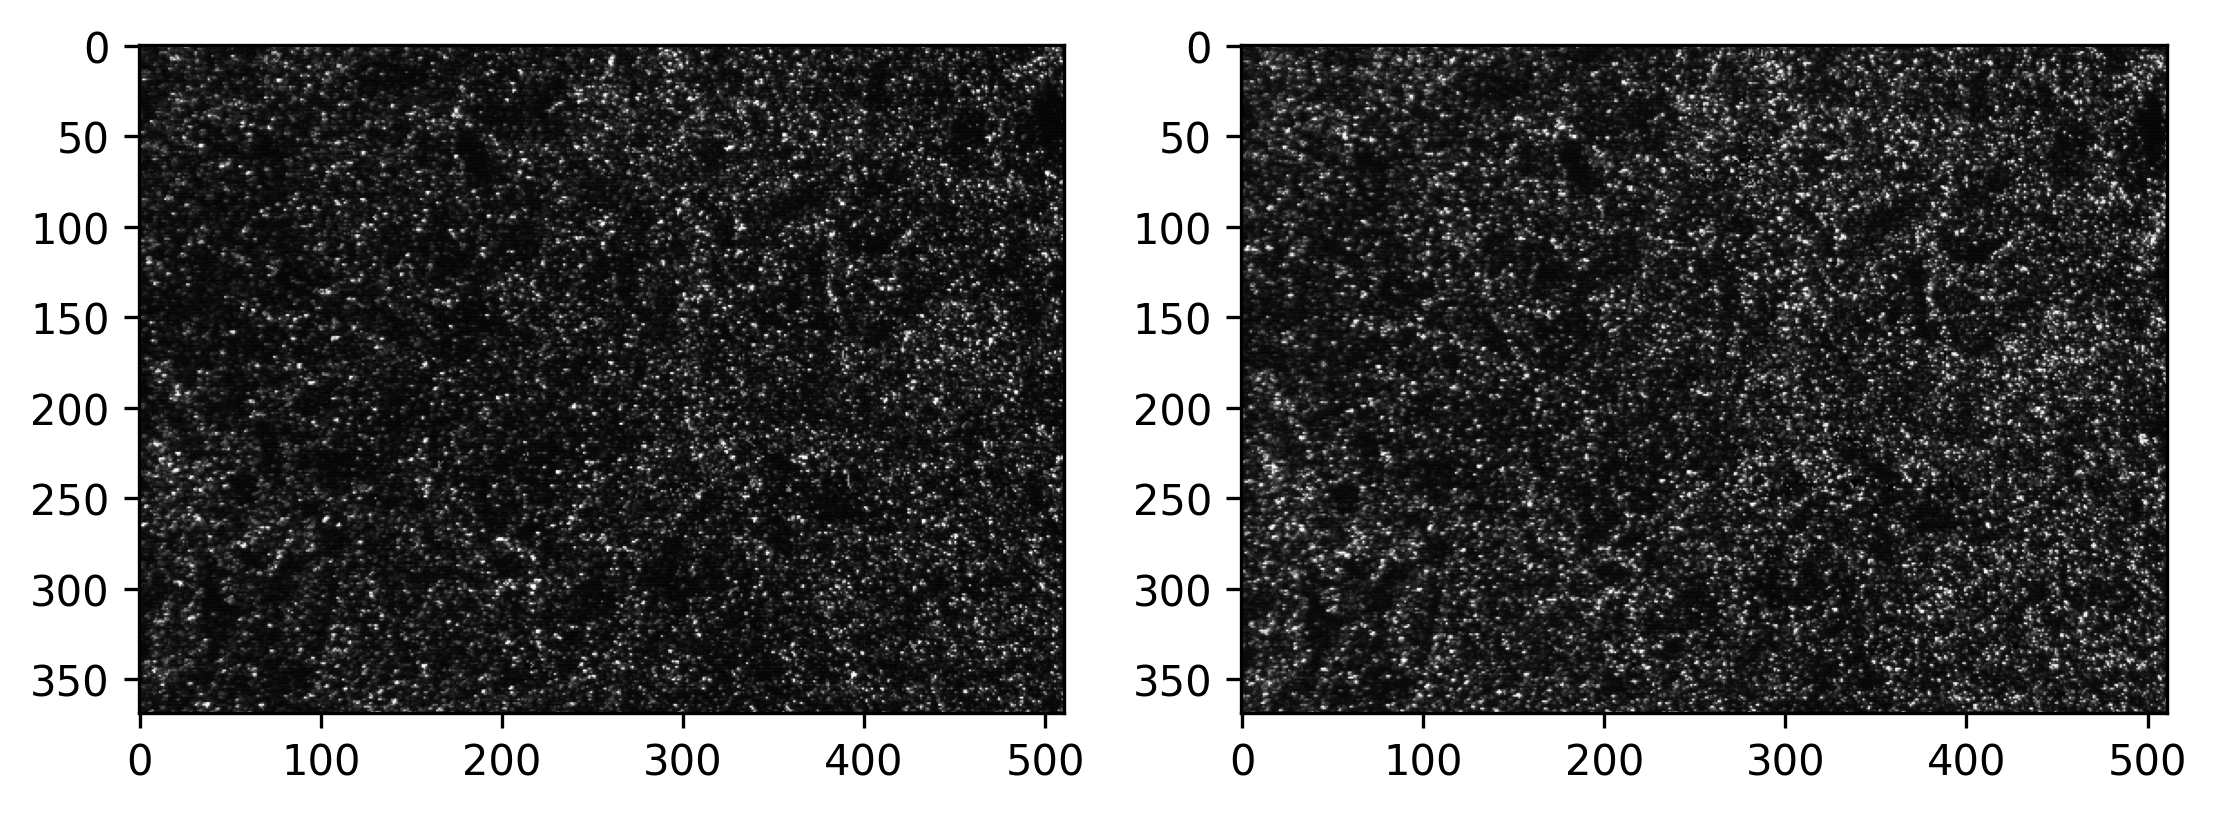

In [5]:
# Show the particle images.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 9), dpi=300, tight_layout=True)
ax1.imshow(frame_a, cmap='gray')
ax2.imshow(frame_b, cmap='gray')
plt.show()


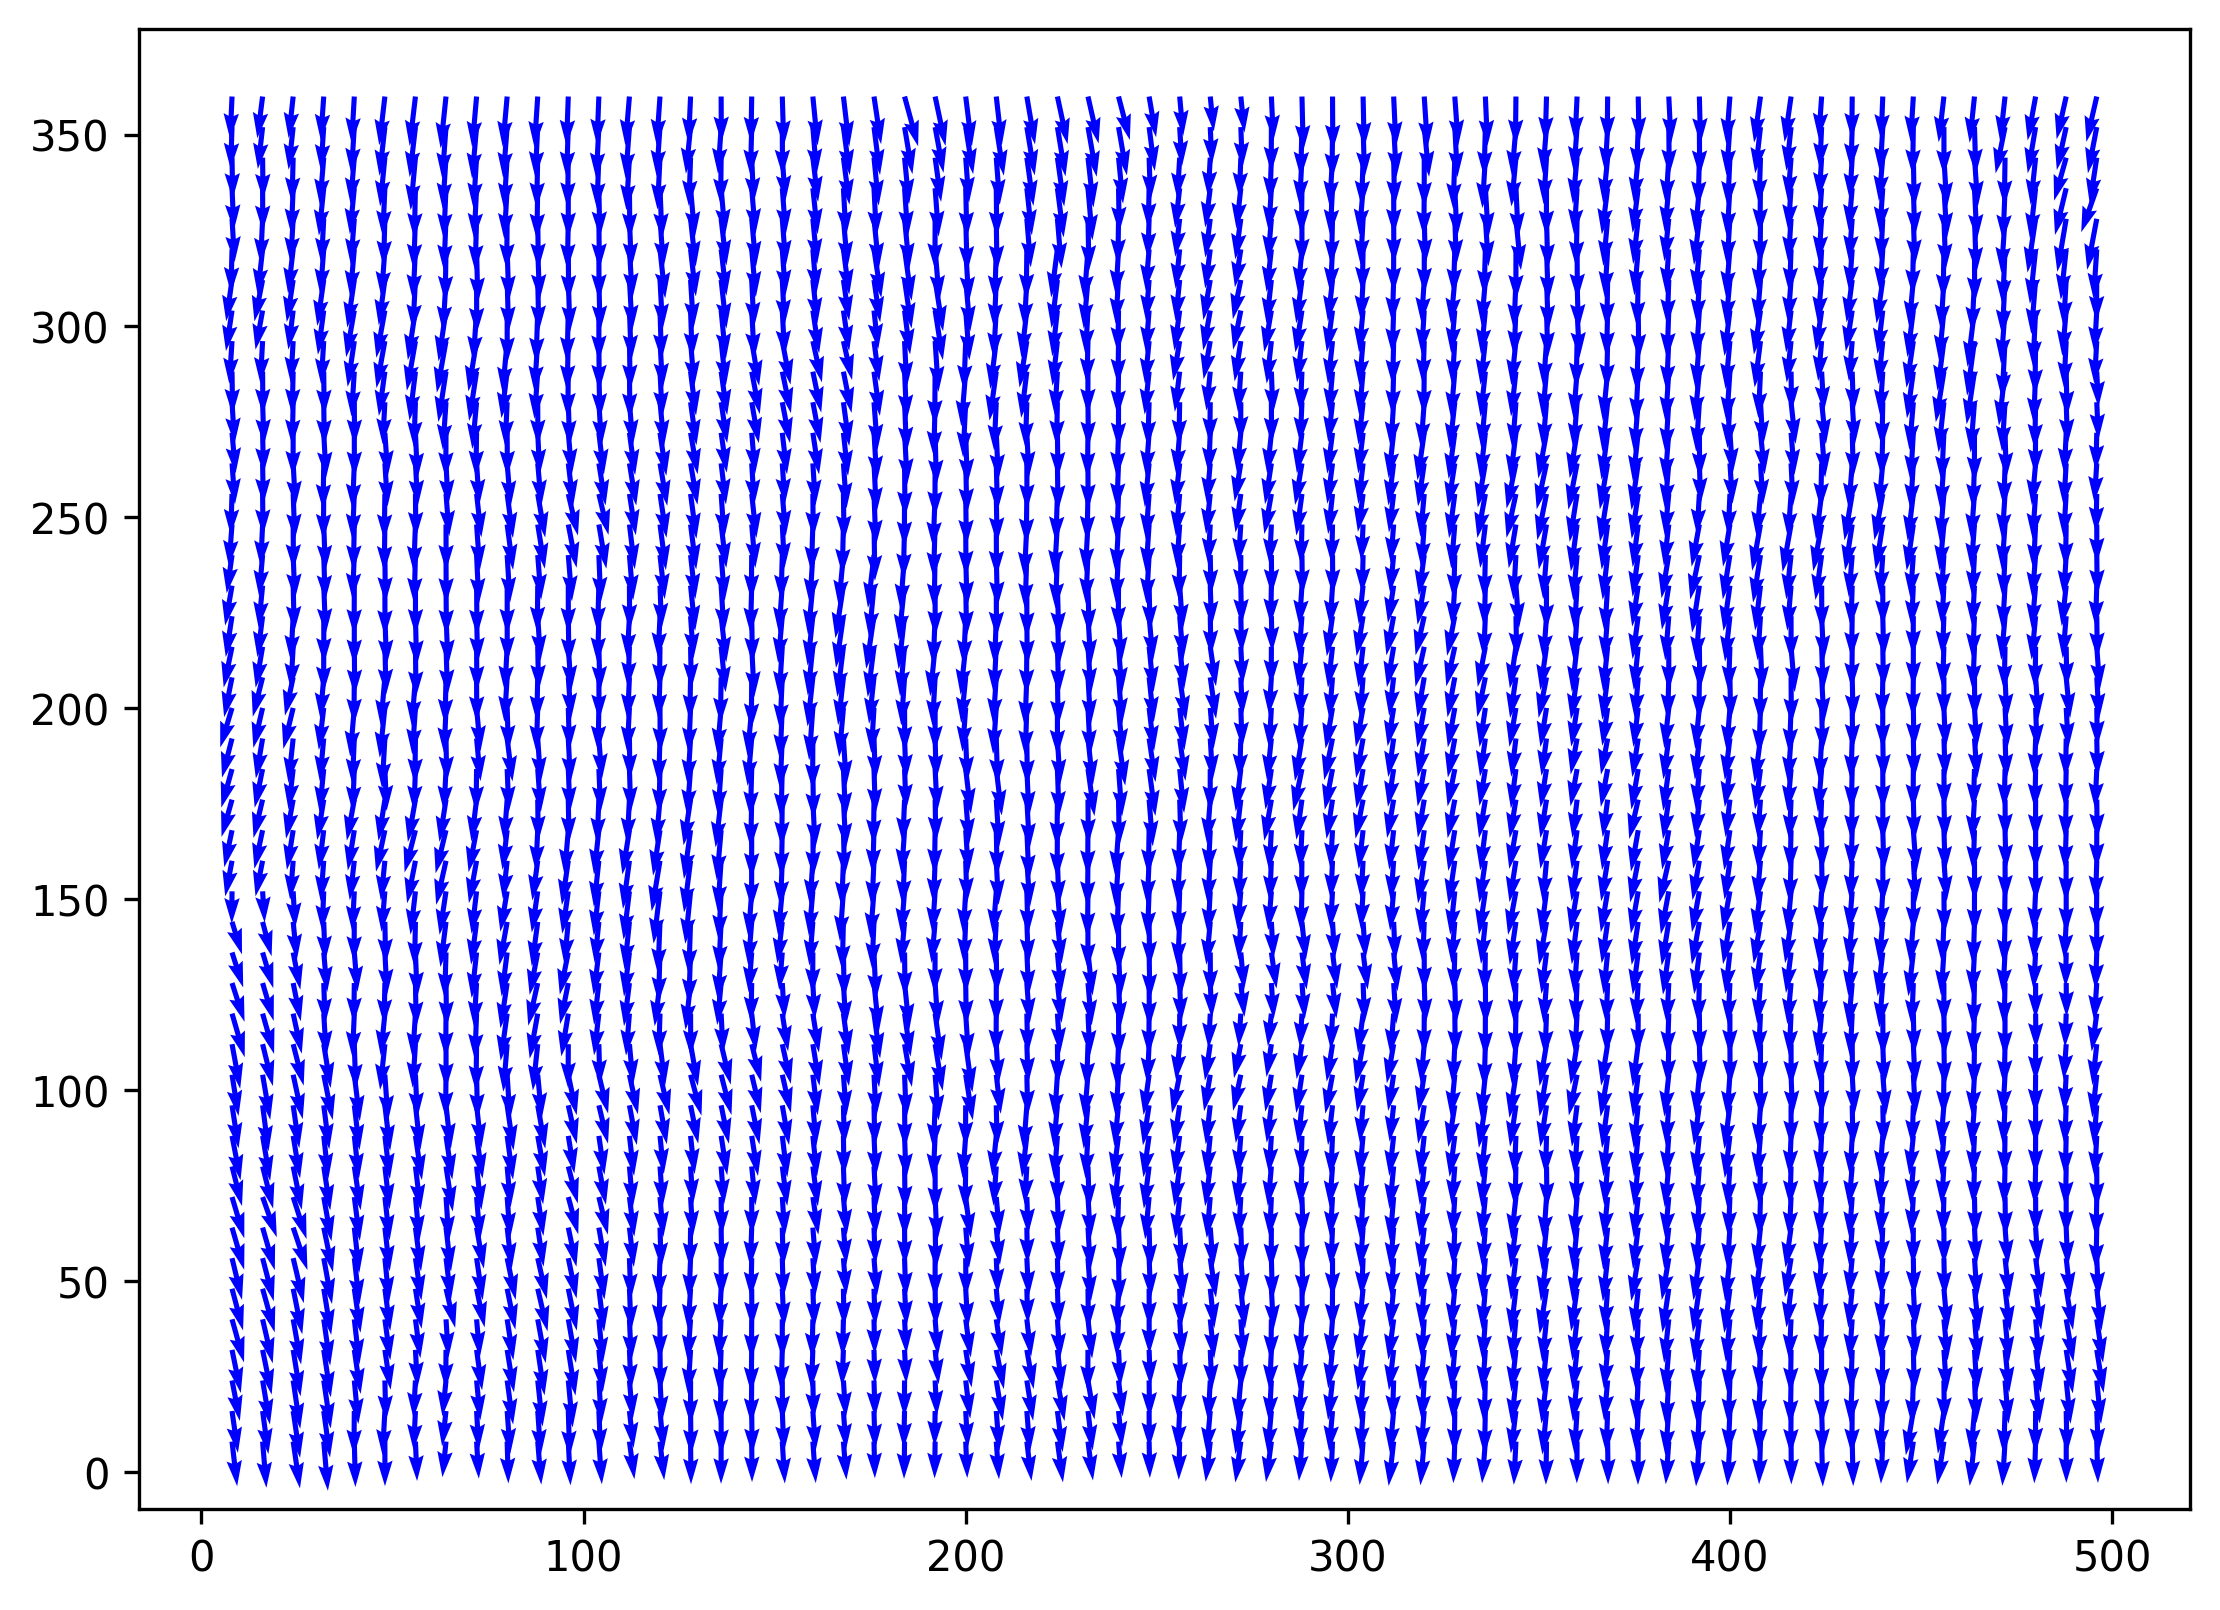

In [6]:
# The results can be visualized using the openpiv.tools module.
fig, ax = plt.subplots(figsize=(7.5, 9), dpi=300, tight_layout=True)
tools.display_vector_field('exp1_001_gpu.txt', ax=ax, scale=250, width=0.0025)
plt.show()
